In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pylab as plt

from functools import partial

import theano.tensor as tt
from theano.tensor import slinalg
from theano import shared
cholesky = slinalg.cholesky

from pymc3 import Model, sample, Metropolis, advi, Deterministic, Mixture
from pymc3 import DensityDist, CategoricalGibbsMetropolis
from pymc3.distributions import *
from pymc3.gp import cov, gp, mean
from pymc3 import advi, adam, fit

DATA_DIR = '../data/clean/'

In [2]:
bmi_by_patient = (pd.read_csv(DATA_DIR+'bmi_by_patient.csv', index_col=0)
                      .dropna(axis=1, thresh=5))
bmi_by_patient.head()

,1621101,1685338,1713205,1958537,2025534,2062537,2087799,2129427,2186450,2382232,...,40985475,41005570,41014622,41014655,41043167,41052325,41054388,41077231,41087032,41248451
Days,,,,,,,,,,,,,,,,,,,,,
0,27.464844,NaN,29.679341,27.51063,27.032689,27.484552,29.380994,27.614212,29.743767,28.201669,...,27.777479,29.785761,28.921647,NaN,28.096818,28.663549,27.26058,27.125971,27.423469,28.801188
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.785761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.695456
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.969401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.209745
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29.030746,NaN,NaN,NaN,NaN,NaN,NaN,28.695456
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
bmi_by_patient.index =  pd.to_datetime(bmi_by_patient.index, unit='D')

In [4]:
bmi_resampled = bmi_by_patient.resample('2W').mean()
bmi_resampled.shape

(27, 5915)

In [5]:
# data_subset = bmi_resampled.copy()
data_subset = bmi_resampled.iloc[:, :300]

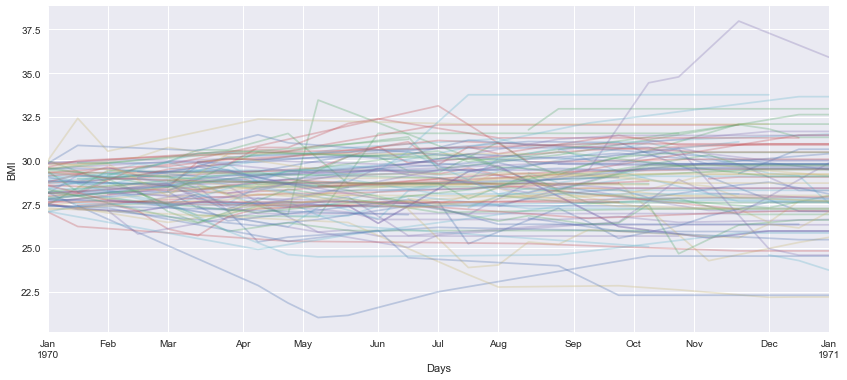

In [6]:
fig, axes = plt.subplots(figsize=(14,6))
(bmi_resampled[np.random.choice(bmi_resampled.columns, 100)].interpolate(limit=10)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('BMI');

In [7]:
data_subset.shape

(27, 300)

Stick-breaking function for Dirichlet process

In [8]:
def stick_breaking(beta, complete=False):
    
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    p = beta * portion_remaining
    if not complete:
        return p
    return tt.concatenate([p, [1-p.sum()]])

Maximum number of groups

In [9]:
CLUSTERS = 15
D, N = data_subset.shape

In [10]:
data_missing = np.ma.masked_equal(data_subset.fillna(42).values, 42).T

In [11]:
data_missing.shape

(300, 27)

In [12]:
nknots = 10
knots = np.linspace(0, 100, nknots)

In [13]:
basis_funcs = sp.interpolate.BSpline(knots, np.eye(nknots), k=3)

In [14]:
X = np.arange(D).reshape(-1, 1)

In [15]:
def interpolate(x0, y0, x):

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [16]:
with Model() as model:
    
    α = Gamma('α', 1., 1.)
    β = Beta('β', 1., α, shape=CLUSTERS)
    ω = Deterministic('ω', stick_breaking(β))
    
    z = Categorical('z', ω, shape=N)
    
    σ = HalfCauchy('σ', 5, shape=CLUSTERS)

    θ = tt.stack([GaussianRandomWalk('θ_%i' % i, sd=σ[i], shape=nknots) for i in range(CLUSTERS)])

    sd = HalfCauchy('sd', 5)
    
    trajectories = [[] for i in range(D-1)]
    
    for i in range(N):
        
        data = data_subset.iloc[:, i]
        observed = ~np.isnan(data)
        y = data[observed].values
        x = np.argwhere(observed)
        n = y.shape[0]
                
        trajectories[n-1].append(Normal('trajectory_%i' % i, 
                                        interpolate(knots, θ[z[i]], x), sd=sd, observed=y))
        
    trajectories = [tt.stack(t) for t in trajectories if t]



In [ ]:
with model:
    trace = sample(1000, njobs=2)

Assigned NUTS to α_log__
Assigned NUTS to β_logodds__
Assigned CategoricalGibbsMetropolis to z
Assigned NUTS to σ_log__
Assigned NUTS to θ_0
Assigned NUTS to θ_1
Assigned NUTS to θ_2
Assigned NUTS to θ_3
Assigned NUTS to θ_4
Assigned NUTS to θ_5
Assigned NUTS to θ_6
Assigned NUTS to θ_7
Assigned NUTS to θ_8
Assigned NUTS to θ_9
Assigned NUTS to θ_10
Assigned NUTS to θ_11
Assigned NUTS to θ_12
Assigned NUTS to θ_13
Assigned NUTS to θ_14
Assigned NUTS to sd_log__


In [22]:
from pymc3 import traceplot, forestplot

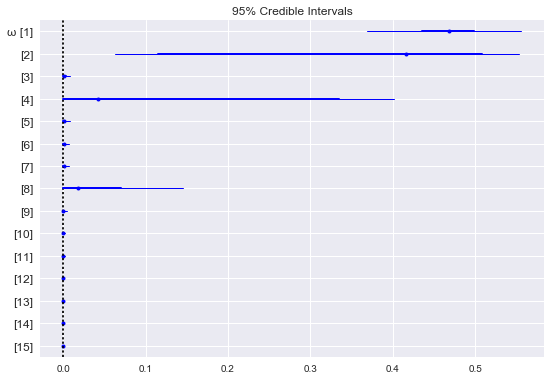

In [23]:
forestplot(trace, varnames=['ω'])

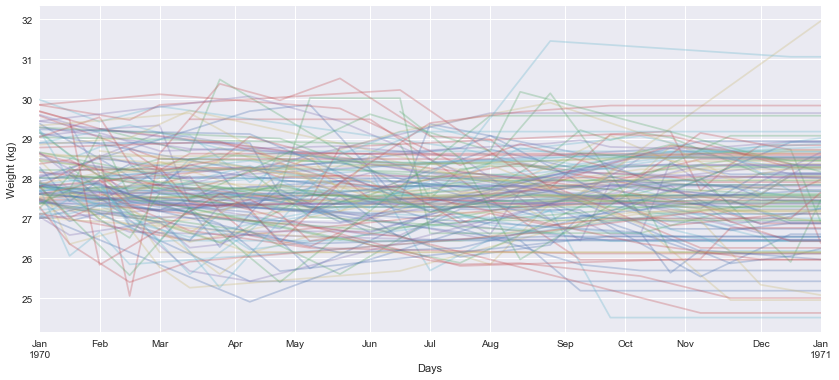

In [24]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==0].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

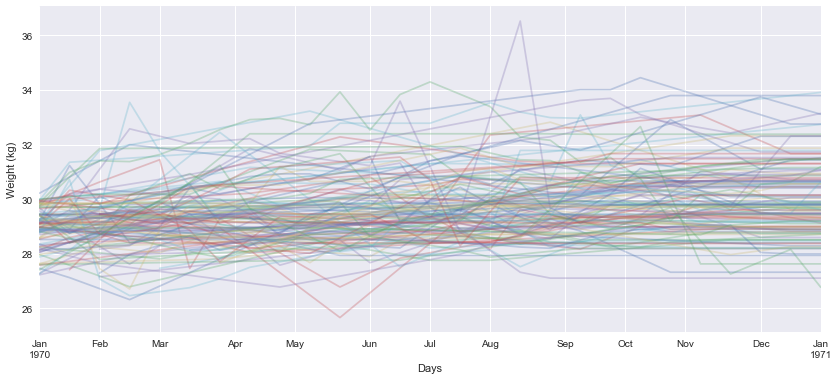

In [25]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==1].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

TypeError: Empty 'DataFrame': no numeric data to plot

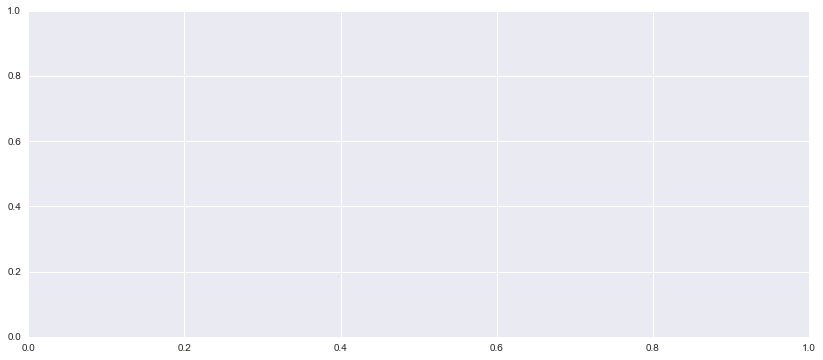

In [26]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==2].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

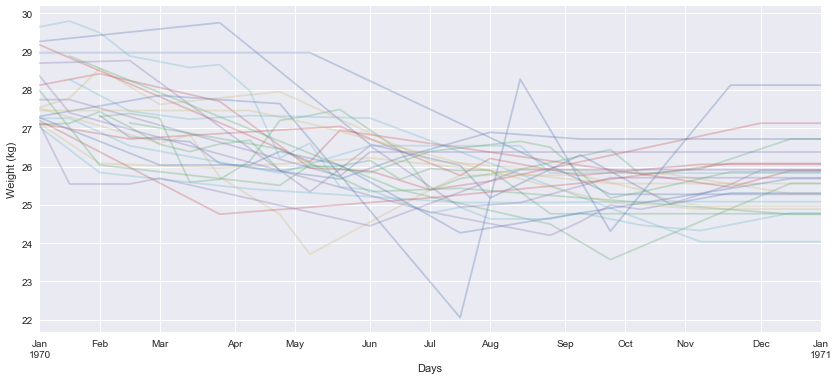

In [27]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==3].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

TypeError: Empty 'DataFrame': no numeric data to plot

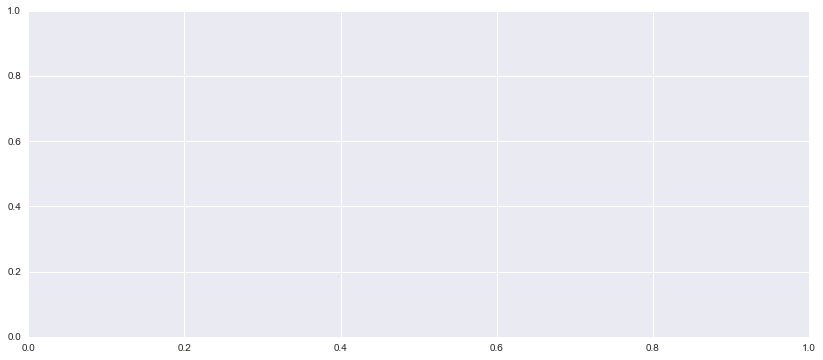

In [28]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==4].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

TypeError: Empty 'DataFrame': no numeric data to plot

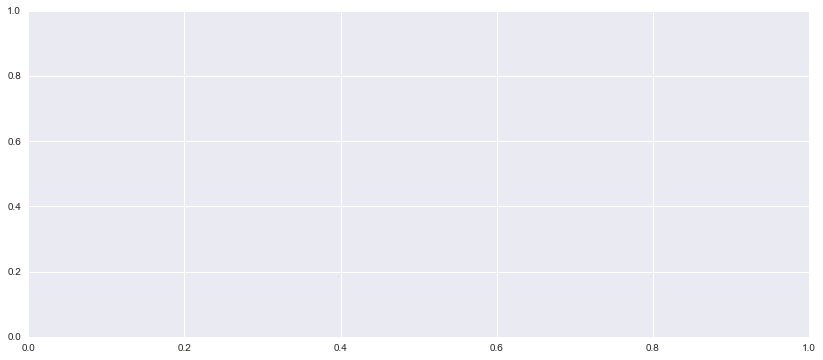

In [29]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==5].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

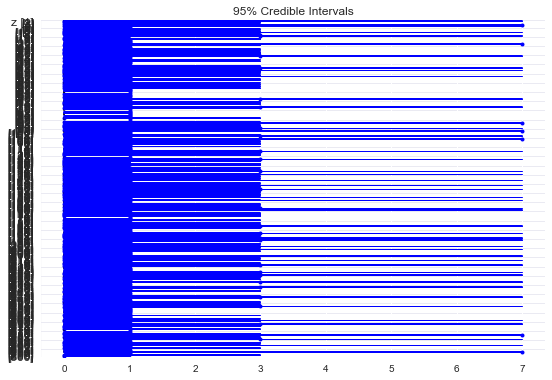

In [30]:
forestplot(trace, varnames=['z'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1db24b630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1db3df748>]], dtype=object)

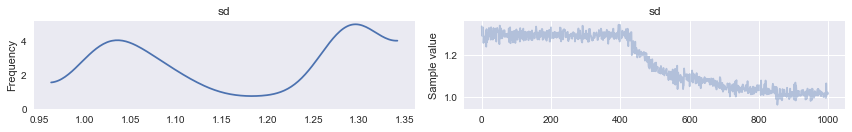

In [31]:
traceplot(trace, varnames=['sd'])